In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
import random
from ipynb.fs.full.call_sign_times import call_sign_times

In [340]:
data = r"clean_cad.csv"
clean_data = pd.read_csv(data)
clean_data["Call Time"] = pd.to_datetime(clean_data["Call Time"], errors='coerce')
clean_data

,Unnamed: 0,Call Time,Reason for Dispatch,Call Sign,2 Call Sign,Disposition
0,0,2016-01-01 00:00:04,ASSAULT,5E57,5E57,ADVISED
1,1,2016-01-01 00:00:04,ASSAULT,5E57,4X40,ADVISED
2,2,2016-01-01 00:00:04,ASSAULT,5E57,4E53,ADVISED
3,3,2016-01-01 00:00:24,TRAFFIC STOP,5T81,5T81,ADVISED
4,4,2016-01-01 00:02:45,CHECK WELFARE,3X90,3F61,ASSISTED
...,...,...,...,...,...,...
1267985,1616812,2023-12-31 22:44:38,DISPUTE,6E19,4K97,REPORT TAKEN
1267986,1616813,2023-12-31 22:44:38,DISPUTE,6E19,6E19,REPORT TAKEN
1267987,1616814,2023-12-31 22:44:38,DISPUTE,6E19,5X51,REPORT TAKEN
1267988,1616817,2023-12-31 22:56:40,TRAFFIC STOP,4F74,4F72,UNIFORM TRAFFIC CITATION ISSUED


In [334]:
def time_filter_year(table: pd.DataFrame, start_time: int, end_time: int):
    """Filters the call time column of the data. Based off year"""
    filtered_table = table[(table["Call Time"].dt.year >= start_time) & (table["Call Time"].dt.year < end_time)]
    return filtered_table

def time_filter_month(table: pd.DataFrame, start_year: int, start_month: int, end_year: int, end_month: int):
    """Filters the 'Call Time' column of the data based on month and year."""
    # Creating a mask to filter data between two datetime boundaries
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    if end_month == 12:
        end_date = pd.Timestamp(year=end_year + 1, month=1, day=1)
    else:
        end_date = pd.Timestamp(year=end_year, month=end_month + 1, day=1)

    filtered_table = table[(table["Call Time"] >= start_date) & (table["Call Time"] < end_date)]
    return filtered_table

In [298]:
def percent_cahoots_calls(df: pd.DataFrame, cahoot_call_signs: list):
    count_cahoots = 0
    for sign in cahoot_call_signs:
        count_cahoots += len(df[(df["Call Sign"] == sign) | (df["2 Call Sign"] == sign)])
    return (count_cahoots / len(df)) * 100

In [299]:
def filter_incidents(df: pd.DataFrame, column_name, incidents: list) -> pd.DataFrame:
    for i in incidents:
        df = df[df[column_name] != i]
    return df

In [300]:
cahoots_call_signs = ["1J77", "3J78", "4J79"]

In [302]:
def calc_monthly_percentages(clean_data: pd.DataFrame, call_signs: list) -> pd.DataFrame:
    percentages = [ ]
    times = [ ]
    for year in range(2016, 2024):
        for month in range(1, 13):  # Months from January (1) to December (12)
            next_month = month + 1 if month < 12 else 1
            next_year = year if month < 12 else year + 1
            month_table = time_filter_month(clean_data, year, month, next_year, next_month)
            percent = percent_cahoots_calls(month_table, call_signs)
            percentages.append(percent)
            times.append(datetime(year=year, month=month, day=1))
            # print(f"In {year}-{month}, Cahoots handled {percent:.2f}% of the total calls")
    return pd.DataFrame({"Time": times, "Percentage": percentages})

results_table = calc_monthly_percentages(clean_data, cahoots_call_signs)

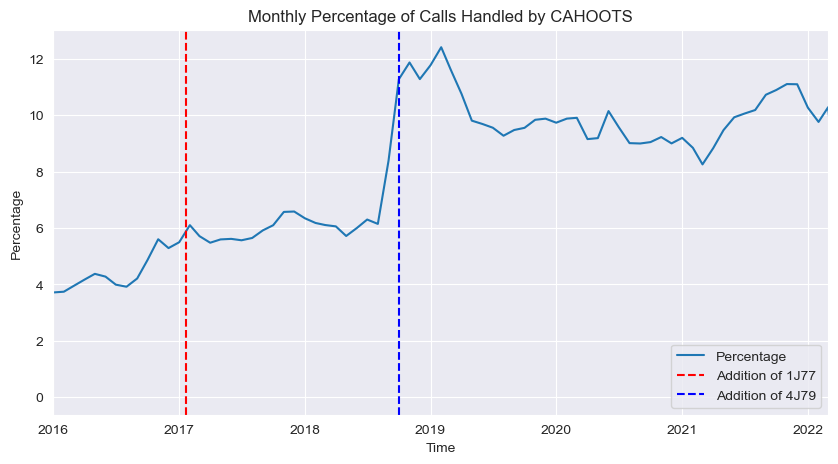

In [304]:
plt.figure(figsize=(10, 5))  
plt.plot(results_table['Time'], results_table['Percentage'], label="Percentage")  
plt.title('Monthly Percentage of Calls Handled by CAHOOTS') 
plt.xlabel('Time')  
plt.ylabel('Percentage')  
plt.grid(True)  

plt.axvline(pd.to_datetime(call_sign_times['1J77']['First']), label='Addition of 1J77', color='r', linestyle='--')
plt.axvline(pd.to_datetime(call_sign_times['4J79']['First']), label='Addition of 4J79', color='b', linestyle='--')

plt.legend(loc="lower right")

plt.xlim([pd.to_datetime("2016"), pd.to_datetime("2022-3-1")])

plt.show()

Dig deeper into uptick in 2018. Added 2nd van? Less total police calls, increase in cahoots calls, or both?
Stick with 2022 data cutoff. 

In [305]:
results_1_shift = calc_monthly_percentages(clean_data, ["3J78"])
results_2_shift = calc_monthly_percentages(clean_data, ["3J78", "1J77"])
results_3_shift = calc_monthly_percentages(clean_data, ["3J78", "1J77", "4J79"])

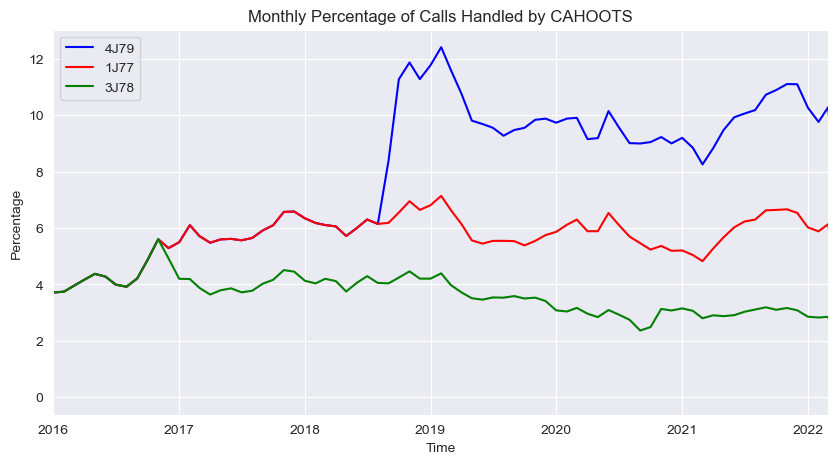

In [306]:
plt.figure(figsize=(10, 5))  # Set the figure size

plt.plot(results_3_shift['Time'], results_3_shift['Percentage'], color='b', label="4J79")
plt.plot(results_2_shift['Time'], results_2_shift['Percentage'], color='r', label="1J77")
plt.plot(results_1_shift['Time'], results_1_shift['Percentage'], color='g', label="3J78")

plt.title('Monthly Percentage of Calls Handled by CAHOOTS')  # Title of the plot
plt.xlabel('Time')  # X-axis label
plt.ylabel('Percentage')  # Y-axis label
plt.grid(True)  # Turn on the grid
plt.legend(loc="upper left")


plt.xlim([pd.to_datetime("2016"), pd.to_datetime("2022-3-1")])

plt.show()

Claims that 1J77 was added on 01-01-2017, I predict there was a slow ramp up (increase in capacity and hiring before adding another shift) 

In [307]:
results_3J78 = calc_monthly_percentages(clean_data, ["3J78"])
results_1J77 = calc_monthly_percentages(clean_data, ["1J77"])
results_4J79 = calc_monthly_percentages(clean_data, ["4J79"])

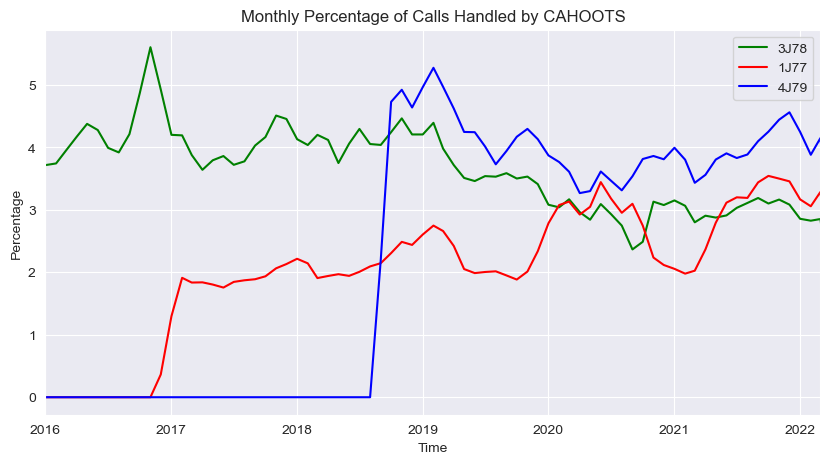

In [308]:

plt.figure(figsize=(10, 5))  # Set the figure size
    
plt.plot(results_3J78['Time'], results_3J78['Percentage'], label="3J78", color='g')
plt.plot(results_1J77['Time'], results_1J77['Percentage'], label="1J77", color='r')
plt.plot(results_4J79['Time'], results_4J79['Percentage'], label="4J79", color='b')
    
plt.title('Monthly Percentage of Calls Handled by CAHOOTS')  # Title of the plot
plt.xlabel('Time')  # X-axis label
plt.ylabel('Percentage')  # Y-axis label
plt.grid(True)  # Turn on the grid
plt.legend(loc='upper right')
    
plt.xlim([pd.to_datetime("2016"), pd.to_datetime("2022-3-1")])
    
plt.show()

## Observations from graph:
- Spike in 3J78 before 5-10 AM service hours were added. Why?
    - Possible ramp up in hiring before added hours?
    - Upgrades to handle longer van hours?
    - Started experimenting with shift before officially implementing it?
    - Going to look at same graph with count and see if it is similar.
    - If you're reading this and have any ideas please let me know!!
- 5 - 10 AM shift does handle fewer calls, in the beginning, however they balance out. Why?
- New van handles 1.35% more calls on average than older one. Is it faster? More comfortable? Better equipment? In all actuality though what changed to make it so consistently more efficient?
- Expected drop in 2020 (Covid) 
